### Import

In [8]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

### DataLoad

In [4]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('../rdkit_data/rdkit_train_corr_0.3.csv')  # 예시 파일 이름
chembl_data.head()

,pIC50,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,BCUT2D_LOGPLOW,BertzCT,Chi0,Chi0n,Chi0v,...,NOCount,NumAromaticCarbocycles,NumAromaticHeterocycles,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,MolMR,fr_NH0,fr_benzene,fr_pyridine
0,10.59,535.624,501.352,535.270716,206,-2.500926,1405.892793,27.310826,22.307719,22.307719,...,10,1,2,8,11,7,144.7415,6,1,0
1,10.11,537.596,505.340,537.249981,206,-2.563125,1408.871656,27.310826,22.008861,22.008861,...,11,1,2,9,12,7,141.7095,6,1,0
2,10.09,545.566,515.326,545.236222,208,-2.476253,1382.863661,27.896612,21.649435,21.649435,...,10,1,2,8,13,8,137.9735,6,1,0
3,10.00,571.604,539.348,571.251873,218,-2.567951,1488.807437,29.103719,22.856542,22.856542,...,10,1,2,8,13,7,145.0715,6,1,0
4,10.00,473.537,446.321,473.217538,180,-2.455375,1448.073885,24.156125,19.769469,19.769469,...,10,1,3,8,10,4,129.4652,6,1,0


In [5]:
target = ['pIC50']
x = chembl_data.drop(target, axis = 1)
y = chembl_data.loc[:, target]

# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=42)

### Train & Validation

In [6]:
# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=CFG['SEED'])

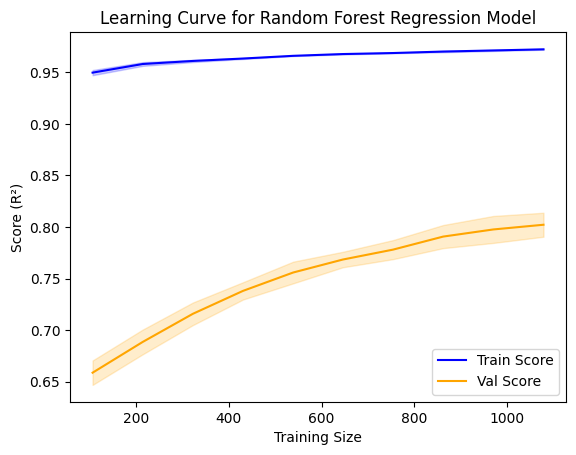

In [7]:
train_sizes, train_scores, val_scores = learning_curve(model, train_x, train_x, cv=5, 
                                                         n_jobs=-1, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10))

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 시각화
plt.plot(train_sizes, train_mean, label='Train Score', color='blue')
plt.plot(train_sizes, val_mean, label='Val Score', color='orange')

# 신뢰구간 표시
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)

plt.title('Learning Curve for Random Forest Regression Model')
plt.xlabel('Training Size')
plt.ylabel('Score (R²)')
plt.legend()
plt.show()

In [9]:
model.fit(train_x, train_y)

c:\Users\ogong\anaconda3\envs\dacon\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [15]:
# pIC50에서 IC50을 계산하는 함수
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Normalized RMSE를 계산하는 함수
def calculate_normalized_rmse(true_pIC50, predicted_pIC50):
    """
    Normalized RMSE 계산.
    Normalized RMSE = RMSE / (max(true_IC50) - min(true_IC50))
    """
    # RMSE 계산
    mse = mean_squared_error(pIC50_to_IC50(true_pIC50), pIC50_to_IC50(predicted_pIC50))
    rmse = np.sqrt(mse)
    # Normalized RMSE 계산
    norm_rmse = rmse / (np.max(pIC50_to_IC50(true_pIC50)) - np.min(pIC50_to_IC50(predicted_pIC50)))
    return norm_rmse

# pIC50에서 Correct Ratio를 계산하는 함수
def calculate_correct_ratio(true_pIC50, predicted_pIC50):
    """
    Correct Ratio 계산.
    Correct Ratio = 1/N * Σ I(Absolute Error <= 0.5)
    """
    # 절대 오차 계산
    abs_errors = np.abs(predicted_pIC50 - true_pIC50)
    # 절대 오차가 0.5 이하인 경우의 수 계산
    correct_count = np.sum(abs_errors <= 0.5)
    # Correct Ratio 계산
    correct_ratio = correct_count / len(true_pIC50)
    return correct_ratio

# 최종 Score를 계산하는 함수
def calculate_score(true_pIC50, predicted_pIC50):
    """
    주어진 실제 IC50 값과 예측 IC50 값을 기반으로 Score 계산.
    Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    """
    # Normalized RMSE 계산 (A 값)
    norm_rmse = calculate_normalized_rmse(true_pIC50, predicted_pIC50)

    # Correct Ratio 계산 (B 값)
    correct_ratio = calculate_correct_ratio(true_pIC50, predicted_pIC50)

    # 최종 Score 계산
    # Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    score = 0.5 * (1 - min(norm_rmse, 1)) + 0.5 * correct_ratio
    
    return score

In [10]:
val_y_pred = model.predict(val_x)
val_y = np.array(val_y)
val_y = val_y.ravel()

In [11]:
r2 = r2_score(val_y, val_y_pred)
print(r2)

0.5631884873201071


In [16]:
norm_rmse = calculate_normalized_rmse(val_y, val_y_pred)
correct_ratio = calculate_correct_ratio(val_y, val_y_pred)
score = calculate_score(val_y, val_y_pred)
print(f"norm_rmse: {norm_rmse:.4f}")
print(f"correct_ratio: {correct_ratio:.4f}")
print(f"Calculated Score: {score:.4f}")

norm_rmse: 0.0815
correct_ratio: 0.6107
Calculated Score: 0.7646


In [12]:
print(model.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(model.feature_importances_, index=x.columns)

# 내림차순 정렬을 이용한다
top = ser.sort_values(ascending=False)[:]
top10 = ser.sort_values(ascending=False)[:10]
print(top10)

[0.00555933 0.01004808 0.00415807 0.00252036 0.08689294 0.02411727
 0.02284765 0.01462105 0.00760976 0.00921449 0.01782472 0.04740252
 0.0198735  0.02850887 0.02111928 0.01066814 0.0203227  0.00621832
 0.00979277 0.04255693 0.02658447 0.03145797 0.02560892 0.04532991
 0.09939596 0.03048416 0.01084051 0.1137561  0.00134981 0.00437444
 0.00320508 0.12614392 0.00679714 0.00451672 0.01450114 0.01031312
 0.01603384 0.00261206 0.01481798] 

NumAromaticHeterocycles    0.126144
VSA_EState1                0.113756
SlogP_VSA5                 0.099396
BCUT2D_LOGPLOW             0.086893
Chi2n                      0.047403
SMR_VSA5                   0.045330
PEOE_VSA4                  0.042557
PEOE_VSA9                  0.031458
TPSA                       0.030484
HallKierAlpha              0.028509
dtype: float64


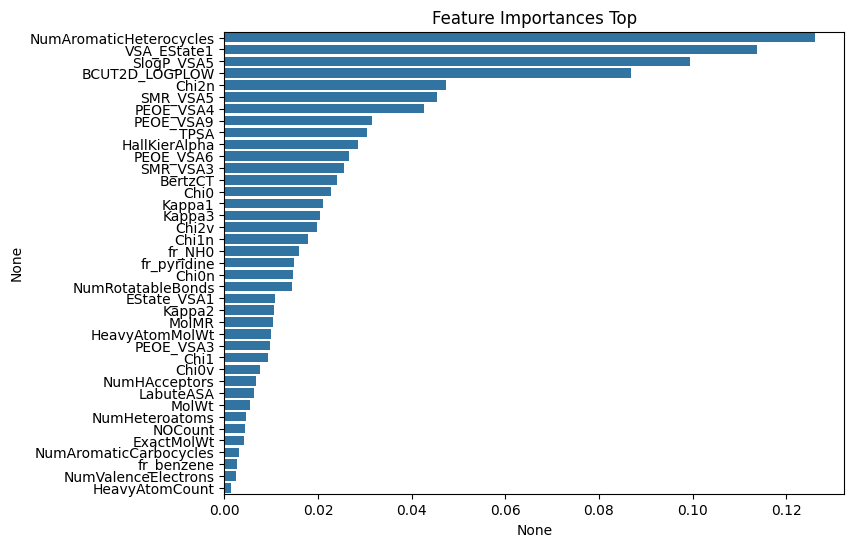

In [13]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top')
sns.barplot(x=top, y=top.index)
plt.show()

### Inference

In [10]:
test = pd.read_csv('./rdkit_test_corr_0.3.csv')

test_y_pred = model.predict(test)

### Submission

In [11]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,24.199144
1,TEST_001,40.117451
2,TEST_002,71.326350
3,TEST_003,22.418162
4,TEST_004,33.071204


In [12]:
submit.to_csv('./corr_0.3_submit.csv', index=False)